### Tutorial 1: Using a MLP to classify handwriting digits

### Information
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

In [23]:
# Load basic packages
import os
import struct
import numpy as np
import sys
import gzip
import shutil
import matplotlib.pyplot as plt

### Step 1: Reading data set 

In [24]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [25]:
#Reading training and testing data sets
if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 


X_train, y_train = load_mnist('', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


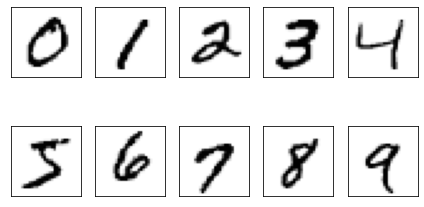

In [26]:
# Visualize the first digit of each class:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

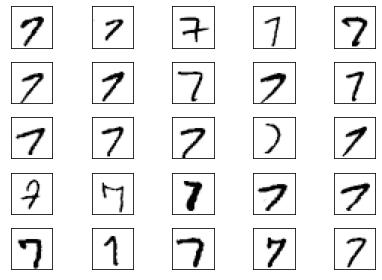

In [27]:
# Visualize 25 different versions of "7":

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

### Step 2: Defining the MLP

In [28]:
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatche_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

### Step 3: Training the MLP

In [29]:
n_epochs = 10

nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])


10/10 | Cost: 25941.66 | Train/Valid Acc.: 93.08%/94.96% 

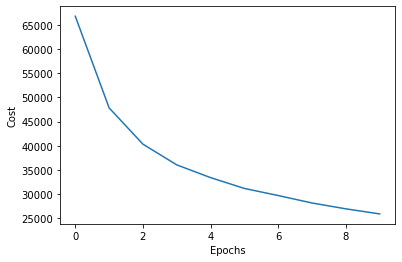

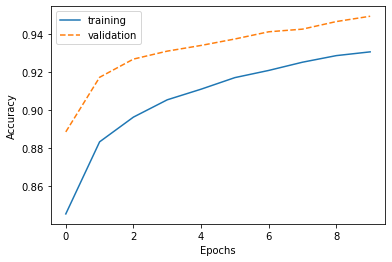

In [30]:
# Plotting the results 

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Solution exercise b first question: Looking at the plot we can notice that the minimum number of epochs necessary to obtain a training error smaller than 0.5 is 25

25/25 | Cost: 17675.95 | Train/Valid Acc.: 95.53%/96.42% 

number of epochs necessary for a train error less than 0.5:25


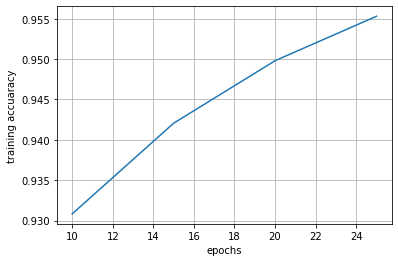

In [31]:
n_epochs = 10
step=5


n_epochs_list=[]
n_epochs_tmp=n_epochs
train_accuracy_per_epoch=[]

while(True):
    
    nn = NeuralNetMLP(n_hidden=100, 
                      l2=0.01, 
                      epochs=n_epochs_tmp, 
                      eta=0.0005,
                      minibatch_size=100, 
                      shuffle=True,
                      seed=1)

    mlp=nn.fit(X_train=X_train[:55000], 
           y_train=y_train[:55000],
           X_valid=X_train[55000:],
           y_valid=y_train[55000:])
    
    training_accuracy=mlp.eval_['train_acc']
    
    if(float(training_accuracy[n_epochs_tmp-1])>=0.95):
        
        train_accuracy_per_epoch.append(training_accuracy[n_epochs_tmp-1])
        n_epochs_list.append(n_epochs_tmp)
        
        print("number of epochs necessary for a train error less than 0.5:{}".format(n_epochs_tmp))
        
        break
        
    train_accuracy_per_epoch.append(training_accuracy[n_epochs_tmp-1])
    n_epochs_list.append(n_epochs_tmp)
    n_epochs_tmp=n_epochs_tmp+step    
    

plt.plot(n_epochs_list,train_accuracy_per_epoch)
plt.xlabel("epochs")
plt.ylabel("training accuaracy")
plt.grid()
plt.show()

Solution exercise b second question: For a number of epochs equals to 25 the accuaracy on the test set is 95.25%

In [32]:
# Apply MLP to test data set 
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

Test accuracy: 95.25%


Solution exercise b third question: Looking at the plot we can notice that if we increase the number of epochs we will reach a point in which the training error continues to decrease, while the test error remains more or less constant to then increase. This means that the model is overfitting. 

25/25 | Cost: 17675.95 | Train/Valid Acc.: 95.53%/96.42% 

test accuracy:0.9525


40/40 | Cost: 13876.48 | Train/Valid Acc.: 96.63%/97.04% 

test accuracy:0.9615


55/55 | Cost: 11505.00 | Train/Valid Acc.: 97.39%/97.40% 

test accuracy:0.9655


70/70 | Cost: 9946.37 | Train/Valid Acc.: 97.84%/97.46%  

test accuracy:0.9684


85/85 | Cost: 8756.33 | Train/Valid Acc.: 98.21%/97.66%  

test accuracy:0.9696


100/100 | Cost: 7909.96 | Train/Valid Acc.: 98.47%/97.78%  

test accuracy:0.9716


115/115 | Cost: 7288.19 | Train/Valid Acc.: 98.66%/97.74%  

test accuracy:0.9723


130/130 | Cost: 6699.08 | Train/Valid Acc.: 98.82%/97.86%  

test accuracy:0.9726


145/145 | Cost: 6228.72 | Train/Valid Acc.: 98.96%/97.88%  

test accuracy:0.9728


160/160 | Cost: 5877.84 | Train/Valid Acc.: 99.07%/97.94%  

test accuracy:0.9734


175/175 | Cost: 5565.07 | Train/Valid Acc.: 99.14%/98.00%  

test accuracy:0.9746


190/190 | Cost: 5235.72 | Train/Valid Acc.: 99.23%/98.06%  

test accuracy:0.9752


205/205 | Cost: 5026.63 | Train/Valid Acc.: 99.29%/98.10%  

test accuracy:0.9746


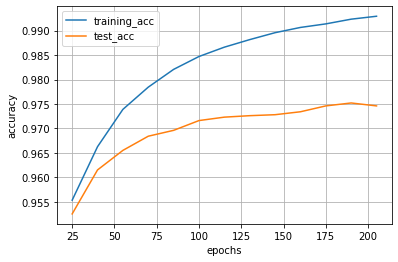

In [17]:
n_epochs = 25
step=15


n_epochs_list=[]
n_epochs_tmp=n_epochs
train_accuracy_per_epoch=[]
test_accuracy_per_epoch=[]

test_accuracy_previous_step=-1

while(True):
    
    nn = NeuralNetMLP(n_hidden=100, 
                      l2=0.01, 
                      epochs=n_epochs_tmp, 
                      eta=0.0005,
                      minibatch_size=100, 
                      shuffle=True,
                      seed=1)

    mlp=nn.fit(X_train=X_train[:55000], 
           y_train=y_train[:55000],
           X_valid=X_train[55000:],
           y_valid=y_train[55000:])
    
    y_test_pred = nn.predict(X_test)
    acc_test = (np.sum(y_test == y_test_pred)
       .astype(float) / X_test.shape[0])
    
    training_accuracy=mlp.eval_['train_acc']
    train_accuracy_per_epoch.append(float(training_accuracy[n_epochs_tmp-1]))
    test_accuracy_per_epoch.append(acc_test)
    print("test accuracy:{}".format(acc_test))
    n_epochs_list.append(n_epochs_tmp)
    
    if(test_accuracy_previous_step>=acc_test):
        
        break
        
    n_epochs_tmp=n_epochs_tmp+step
    test_accuracy_previous_step=acc_test

plt.plot(n_epochs_list,train_accuracy_per_epoch,label="training_acc")
plt.plot(n_epochs_list,test_accuracy_per_epoch,label="test_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

Solution exercise c: For a number of epochs equals to 10, using a learning rate equals to 0.01 we can obtain the best performances on the test set. If we further increase the learning rate, the step is to large for the model to converge to a good solution. 

10/10 | Cost: 3660718.11 | Train/Valid Acc.: 10.37%/11.26% 

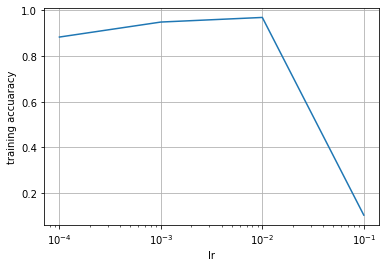

In [33]:
lr_list=[0.0001,0.001,0.01,0.1]
train_accuracy_per_lr=[]

for lr in lr_list:
    
    nn = NeuralNetMLP(n_hidden=100, 
                      l2=0.01, 
                      epochs=10, 
                      eta=lr,
                      minibatch_size=100, 
                      shuffle=True,
                      seed=1)

    mlp=nn.fit(X_train=X_train[:55000], 
           y_train=y_train[:55000],
           X_valid=X_train[55000:],
           y_valid=y_train[55000:])
    
    training_accuracy=mlp.eval_['train_acc']
    train_accuracy_per_lr.append(training_accuracy[-1])
    
    

plt.plot(lr_list,train_accuracy_per_lr)
plt.xticks(lr_list)
plt.xscale('log')
plt.xlabel("lr")
plt.ylabel("training accuaracy")
plt.grid()
plt.show()

Solution exercise d: Increasing the number of hidden units the model will be able to estimate more complex relationships between the inputs, increasing the prediction performances. Of course also the training time will increase. Is necessary to find a compromise between the performances and the complexity of the model. 

10/10 | Cost: 21495.96 | Train/Valid Acc.: 94.95%/96.22%  

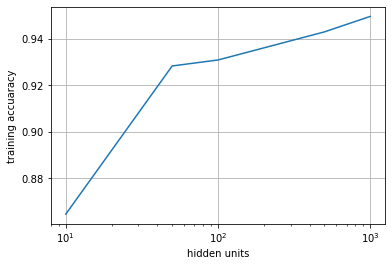

In [36]:
hidden_units=[10,50,100,500,1000]
train_accuracy_per_units=[]

for units_number in hidden_units:
    
    nn = NeuralNetMLP(n_hidden=units_number, 
                      l2=0.01, 
                      epochs=10, 
                      eta=0.0005,
                      minibatch_size=100, 
                      shuffle=True,
                      seed=1)

    mlp=nn.fit(X_train=X_train[:55000], 
           y_train=y_train[:55000],
           X_valid=X_train[55000:],
           y_valid=y_train[55000:])
    
    training_accuracy=mlp.eval_['train_acc']
    train_accuracy_per_units.append(training_accuracy[-1])
    
    

plt.plot(hidden_units,train_accuracy_per_units)
plt.xticks(hidden_units)
plt.xlabel("hidden units")
plt.ylabel("training accuaracy")
plt.xscale('log')
plt.grid()
plt.show()

Solution exercise e: To estimate the global optimum of the hyper-parameters we can adopt a brute force approach. The function ParameterGrid from the lybrary sklearn.model_selection generate all the possible combinations of the hyper-parameters, given a list of possible values for each hyper-parameter. We can then iterate over all the possible combinations evaluating each time the performances of the model using the K-fold technique. Using the K-fold technique we can evaluate the performances of the model using different sets of data reducing the possibility of overfitting. At the end of the hyper-parameter search we can identify the best of hyper-parameters for our task. The class KFold() from the lybrary sklearn.model_selection can be used to generate the indexes necessary to apply the K-fold technique. 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid

n_hidden_values=[50,100]
l2_values=[0.001,0.01]
epochs_values=[10,100]
eta_values=[0.001,0.01]
minibatch_size_values=[100]
shuffle_values=[True]
seed_values=[1]

parameter_dictionary={'n_hidden':n_hidden_values,
'l2':l2_values,'epochs':epochs_values,'eta':eta_values,'minibatch_size':minibatch_size_values,
'shuffle':shuffle_values,'seed':seed_values}

parameter_combination=ParameterGrid(parameter_dictionary)
#print(list(parameter_combination))
number_best_sets=5
best_validation_accuracy_list=[]
best_sets_hyper_parameters=[]
n_split=3

kfold=KFold(n_split)

for parameters in list(parameter_combination):
    print("analyzing parameters:{}".format(parameters))
    
    accuracies_kfold=[]
    
    for train_indexes,validation_indexes in kfold.split(X_train):
        nn = NeuralNetMLP(**parameters)
        mlp=nn.fit(X_train=X_train[train_indexes], 
               y_train=y_train[train_indexes],
               X_valid=X_train[validation_indexes],
               y_valid=y_train[validation_indexes])
        accuracies_kfold.append(mlp.eval_['valid_acc'][-1])
        
    validation_acc=np.mean(np.array(accuracies_kfold))
    
    print("accuracy score for hyper-parameters:{} is:{}".format(parameters,validation_acc))
    
    if(len(best_validation_accuracy_list)==0):
        best_validation_accuracy_list.append(validation_acc)
        best_sets_hyper_parameters.append(parameters)
        print(best_validation_accuracy_list)
        print(best_sets_hyper_parameters)
        continue
        
    for i,score in enumerate(best_validation_accuracy_list):
    
        if(validation_acc>score):
            if(i<=len(best_validation_accuracy_list)):

                if(len(best_validation_accuracy_list)<number_best_sets):
                    best_validation_accuracy_list.insert(i,validation_acc)
                    best_sets_hyper_parameters.insert(i,parameters)

                else:
                    best_validation_accuracy_list.insert(i,validation_acc)
                    best_sets_hyper_parameters.insert(i,parameters)
                    best_validation_accuracy_list.pop(-1)
                    best_sets_hyper_parameters.pop(-1)
                break
            
    print(best_validation_accuracy_list)
    print(best_sets_hyper_parameters)

analyzing parameters:{'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}


10/10 | Cost: 16932.83 | Train/Valid Acc.: 93.88%/93.09% 

accuracy score for hyper-parameters:{'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True} is:0.9287166666666667
[0.9287166666666667]
[{'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}


10/10 | Cost: 15795.49 | Train/Valid Acc.: 94.25%/93.64% 

accuracy score for hyper-parameters:{'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True} is:0.9354
[0.9354, 0.9287166666666667]
[{'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 10, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}


10/10 | Cost: 17086.36 | Train/Valid Acc.: 93.85%/93.09% 

accuracy score for hyper-parameters:{'epochs': 10, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True} is:0.9285333333333333
[0.9354, 0.9287166666666667]
[{'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 10, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}


10/10 | Cost: 15967.24 | Train/Valid Acc.: 94.23%/93.58% 

accuracy score for hyper-parameters:{'epochs': 10, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True} is:0.9350499999999999
[0.9354, 0.9350499999999999, 0.9287166666666667]
[{'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}


10/10 | Cost: 12316.49 | Train/Valid Acc.: 95.36%/94.16% 

accuracy score for hyper-parameters:{'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True} is:0.9306666666666668
[0.9354, 0.9350499999999999, 0.9306666666666668, 0.9287166666666667]
[{'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}


10/10 | Cost: 11097.46 | Train/Valid Acc.: 95.85%/94.54% 

accuracy score for hyper-parameters:{'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True} is:0.9441
[0.9441, 0.9354, 0.9350499999999999, 0.9306666666666668, 0.9287166666666667]
[{'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 10, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}


10/10 | Cost: 14347.43 | Train/Valid Acc.: 94.67%/93.64% 

accuracy score for hyper-parameters:{'epochs': 10, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True} is:0.9327
[0.9441, 0.9354, 0.9350499999999999, 0.9327, 0.9306666666666668]
[{'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 10, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}


10/10 | Cost: 12015.48 | Train/Valid Acc.: 95.69%/94.25% 

accuracy score for hyper-parameters:{'epochs': 10, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True} is:0.9434
[0.9441, 0.9434, 0.9354, 0.9350499999999999, 0.9327]
[{'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}


100/100 | Cost: 5189.08 | Train/Valid Acc.: 98.71%/96.05%  

accuracy score for hyper-parameters:{'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True} is:0.9600333333333334
[0.9600333333333334, 0.9441, 0.9434, 0.9354, 0.9350499999999999]
[{'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}


100/100 | Cost: 3198.37 | Train/Valid Acc.: 99.42%/96.87%  

accuracy score for hyper-parameters:{'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True} is:0.9685333333333334
[0.9685333333333334, 0.9600333333333334, 0.9441, 0.9434, 0.9354]
[{'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}


100/100 | Cost: 6072.67 | Train/Valid Acc.: 98.46%/96.07%  

accuracy score for hyper-parameters:{'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True} is:0.9607
[0.9685333333333334, 0.9607, 0.9600333333333334, 0.9441, 0.9434]
[{'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}


100/100 | Cost: 4030.93 | Train/Valid Acc.: 99.20%/96.92%  

accuracy score for hyper-parameters:{'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True} is:0.9688166666666667
[0.9688166666666667, 0.9685333333333334, 0.9607, 0.9600333333333334, 0.9441]
[{'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 10, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 100, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}


100/100 | Cost: 3929.59 | Train/Valid Acc.: 99.07%/95.55%  

accuracy score for hyper-parameters:{'epochs': 100, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True} is:0.9530166666666666
[0.9688166666666667, 0.9685333333333334, 0.9607, 0.9600333333333334, 0.9530166666666666]
[{'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 100, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}


100/100 | Cost: 1371.44 | Train/Valid Acc.: 99.83%/96.23%  

accuracy score for hyper-parameters:{'epochs': 100, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True} is:0.9620166666666666
[0.9688166666666667, 0.9685333333333334, 0.9620166666666666, 0.9607, 0.9600333333333334]
[{'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 100, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}


100/100 | Cost: 7087.23 | Train/Valid Acc.: 97.98%/95.79%  

accuracy score for hyper-parameters:{'epochs': 100, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True} is:0.9570500000000001
[0.9688166666666667, 0.9685333333333334, 0.9620166666666666, 0.9607, 0.9600333333333334]
[{'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.01, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}, {'epochs': 100, 'eta': 0.001, 'l2': 0.001, 'minibatch_size': 100, 'n_hidden': 50, 'seed': 1, 'shuffle': True}]
analyzing parameters:{'epochs': 100, 'eta': 0.01, 'l2': 0.01, 'minibatch_size': 100, 'n_hidden': 100, 'seed': 1, 'shuffle': True}


095/100 | Cost: 4003.70 | Train/Valid Acc.: 99.06%/96.79%  

### Step 4: Testing the MLP 

In [47]:
# Apply MLP to test data set 
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

Test accuracy: 93.07%


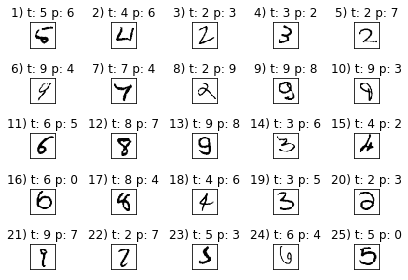

In [48]:
# Show some mismatches  
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()